## Data preparation and cleaning



In [1]:
import pandas as pd
import sqlite3

In [2]:
# Load the dataset
dataset_path = 'Customer_support_data.csv'  # Make sure the file path matches where you've uploaded your file in Colab
data = pd.read_csv(dataset_path)

# Optionally rename columns for consistency or clarity (example provided)
data.rename(columns={'Customer Remarks': 'Customer_Remarks', 'CSAT Score': 'CSAT_Score'}, inplace=True)

# Print the first few rows of the dataset to confirm it's loaded correctly
print("First few rows of the dataset:")
print(data.head())

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('customer_support.db')

# Create a table named 'customer_support' and import the DataFrame into the database
# If the table already exists, 'replace' it
data.to_sql('customer_support', conn, if_exists='replace', index=False)

# Using a cursor to query the database and print each row in the 'customer_support' table
cur = conn.cursor()
print("\nSample rows from the 'customer_support' table:")
for row in cur.execute('SELECT * FROM customer_support LIMIT 5'):  # Adjust the LIMIT for more or fewer rows
    print(row)

# Close the connection to the database
conn.close()

# Confirm that the database operations are complete
print("\nDatabase operations completed successfully.")


First few rows of the dataset:
                              Unique id channel_name         category  \
0  7e9ae164-6a8b-4521-a2d4-58f7c9fff13f      Outcall  Product Queries   
1  b07ec1b0-f376-43b6-86df-ec03da3b2e16      Outcall  Product Queries   
2  200814dd-27c7-4149-ba2b-bd3af3092880      Inbound    Order Related   
3  eb0d3e53-c1ca-42d3-8486-e42c8d622135      Inbound          Returns   
4  ba903143-1e54-406c-b969-46c52f92e5df      Inbound     Cancellation   

                   Sub-category Customer_Remarks  \
0                Life Insurance              NaN   
1  Product Specific Information              NaN   
2             Installation/demo              NaN   
3        Reverse Pickup Enquiry              NaN   
4                    Not Needed              NaN   

                               Order_id order_date_time Issue_reported at  \
0  c27c9bb4-fa36-4140-9f1f-21009254ffdb             NaN  01/08/2023 11:13   
1  d406b0c7-ce17-4654-b9de-f08d421254bd             NaN  01/08/

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect('customer_support.db')

# Load data from the customer_support table into a DataFrame
customer_support_df = pd.read_sql_query("SELECT * FROM customer_support", conn)

# Print DataFrame information to get a summary including the number of non-null entries per column
print("DataFrame Information:")
print(customer_support_df.info())

# Generate and print descriptive statistics for numeric columns
print("\nDescriptive Statistics:")
print(customer_support_df.describe())

# Print the first few rows of the DataFrame to get an idea of the data structure
print("\nFirst 5 Rows of the DataFrame:")
print(customer_support_df.head())

# Count and print the number of missing values in each column
print("\nCount of Null Values in Each Column:")
print(customer_support_df.isnull().sum())

num_rows_no_nulls = customer_support_df.dropna().shape[0]
print(f"Number of rows with no null values: {num_rows_no_nulls}")

total_rows = customer_support_df.shape[0]
print(f"Total number of rows: {total_rows}")
# Close the database connection
conn.close()


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unique id                85907 non-null  object 
 1   channel_name             85907 non-null  object 
 2   category                 85907 non-null  object 
 3   Sub-category             85907 non-null  object 
 4   Customer_Remarks         28756 non-null  object 
 5   Order_id                 67675 non-null  object 
 6   order_date_time          17214 non-null  object 
 7   Issue_reported at        85907 non-null  object 
 8   issue_responded          85907 non-null  object 
 9   Survey_response_Date     85907 non-null  object 
 10  Customer_City            17079 non-null  object 
 11  Product_category         17196 non-null  object 
 12  Item_price               17206 non-null  float64
 13  connected_handling_time  242 non-null    float64
 14 

In [4]:
# Assuming your dataframe is named 'customer_support_df' and has been loaded correctly

# Convert the columns to datetime
customer_support_df['order_date_time'] = pd.to_datetime(customer_support_df['order_date_time'], dayfirst=True)
customer_support_df['Issue_reported at'] = pd.to_datetime(customer_support_df['Issue_reported at'],dayfirst=True)
customer_support_df['issue_responded'] = pd.to_datetime(customer_support_df['issue_responded'],dayfirst=True)
customer_support_df['Survey_response_Date'] = pd.to_datetime(customer_support_df['Survey_response_Date'],dayfirst=True)

# Calculate response time (in whatever time unit is appropriate, e.g., minutes)
customer_support_df['response_time_minutes'] = (customer_support_df['issue_responded'] - customer_support_df['Issue_reported at']).dt.total_seconds() / 60

# Extract hour of day for order and issue reported time
customer_support_df['order_hour_of_day'] = customer_support_df['order_date_time'].dt.hour
customer_support_df['issue_reported_hour_of_day'] = customer_support_df['Issue_reported at'].dt.hour

# Extract day of the week (0=Monday, 6=Sunday)
customer_support_df['order_day_of_week'] = customer_support_df['order_date_time'].dt.dayofweek
customer_support_df['issue_reported_day_of_week'] = customer_support_df['Issue_reported at'].dt.dayofweek

# Calculate elapsed time from order to survey response (in days)
customer_support_df['elapsed_days_to_survey'] = (customer_support_df['Survey_response_Date'] - customer_support_df['order_date_time']).dt.total_seconds() / (60 * 60 * 24)

# Now, your dataframe will have the new columns with the calculated data
# Print DataFrame information to get a summary including the number of non-null entries per column
print("DataFrame Information:")
print(customer_support_df.info())

# Generate and print descriptive statistics for numeric columns
print("\nDescriptive Statistics:")
print(customer_support_df.describe())

# Print the first few rows of the DataFrame to get an idea of the data structure
print("\nFirst 5 Rows of the DataFrame:")
print(customer_support_df.head())

# Count and print the number of missing values in each column
print("\nCount of Null Values in Each Column:")
print(customer_support_df.isnull().sum())

num_rows_no_nulls = customer_support_df.dropna().shape[0]
print(f"Number of rows with no null values: {num_rows_no_nulls}")

total_rows = customer_support_df.shape[0]
print(f"Total number of rows: {total_rows}")
# Close the database connection
conn.close()


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unique id                   85907 non-null  object        
 1   channel_name                85907 non-null  object        
 2   category                    85907 non-null  object        
 3   Sub-category                85907 non-null  object        
 4   Customer_Remarks            28756 non-null  object        
 5   Order_id                    67675 non-null  object        
 6   order_date_time             17214 non-null  datetime64[ns]
 7   Issue_reported at           85907 non-null  datetime64[ns]
 8   issue_responded             85907 non-null  datetime64[ns]
 9   Survey_response_Date        85907 non-null  datetime64[ns]
 10  Customer_City               17079 non-null  object        
 11  Product_category            171

In [5]:
# Drop the columns with high null values
customer_support_df.drop(columns=[
    'order_date_time',
    'order_hour_of_day',
    'order_day_of_week',
    'elapsed_days_to_survey',
    'Order_id',
    'Customer_City',
    'Item_price',
    'connected_handling_time',
    'Product_category'
], inplace=True)

# Print the remaining columns and the count of null values in each
print("Remaining columns and the number of null values in each:")
print(customer_support_df.isnull().sum())

num_rows_no_nulls = customer_support_df.dropna().shape[0]
print(f"Number of rows with no null values: {num_rows_no_nulls}")

Remaining columns and the number of null values in each:
Unique id                         0
channel_name                      0
category                          0
Sub-category                      0
Customer_Remarks              57151
Issue_reported at                 0
issue_responded                   0
Survey_response_Date              0
Agent_name                        0
Supervisor                        0
Manager                           0
Tenure Bucket                     0
Agent Shift                       0
CSAT_Score                        0
response_time_minutes             0
issue_reported_hour_of_day        0
issue_reported_day_of_week        0
dtype: int64
Number of rows with no null values: 28756


In [6]:
# Assuming your original DataFrame is named 'customer_support_df'

# Filter the DataFrame to include only rows with no missing values
complete_cases_df = customer_support_df.dropna()

# Connect to a new SQLite database (this will create the database if it doesn't exist)
conn = sqlite3.connect('cleaned_customer_support.db')

# Save the filtered DataFrame as a new table in the SQLite database
complete_cases_df.to_sql('cleaned_customer_support', conn, if_exists='replace', index=False)

# Close the connection
conn.close()



In [7]:
# Connect to the SQLite database
conn = sqlite3.connect('cleaned_customer_support.db')

# Load the table into a pandas DataFrame
cleaned_df = pd.read_sql_query("SELECT * FROM cleaned_customer_support", conn)

# Print basic statistics of the cleaned database
print("Basic statistics of the cleaned database:")
print(cleaned_df.describe())

# Print information about the DataFrame
print("\nInformation about the DataFrame:")
cleaned_df.info()

# Close the database connection
conn.close()


Basic statistics of the cleaned database:
         CSAT_Score  response_time_minutes  issue_reported_hour_of_day  \
count  28756.000000           28756.000000                28756.000000   
mean       4.073619             130.216546                   14.457087   
std        1.559810             593.413600                    5.066877   
min        1.000000           -1437.000000                    0.000000   
25%        4.000000               2.000000                   11.000000   
50%        5.000000               5.000000                   15.000000   
75%        5.000000              29.000000                   19.000000   
max        5.000000            5742.000000                   23.000000   

       issue_reported_day_of_week  
count                28756.000000  
mean                     2.835026  
std                      1.958635  
min                      0.000000  
25%                      1.000000  
50%                      3.000000  
75%                      5.000000  
max

In [8]:
%pip install sklearn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [9]:
from textblob import TextBlob

# Define a function to calculate sentiment
def calculate_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return None

# Apply the function to the Customer_Remarks column
cleaned_df['sentiment_score'] = cleaned_df['Customer_Remarks'].apply(calculate_sentiment)

# Check the first few entries of the new sentiment_score column
print(cleaned_df[['Customer_Remarks', 'sentiment_score']].head(50))

print(cleaned_df.columns)


                                     Customer_Remarks  sentiment_score
0                                           Very good         0.910000
1   Shopzilla app and it's all coustomer care serv...         0.910000
2                                            Very bad        -0.910000
3                                          Something          0.000000
4                                            All good         0.700000
5                                               Good          0.700000
6                                            Godd job         0.000000
7                 Issue not resolved pathetic service        -1.000000
8                                          Excellent          1.000000
9                                          Very good          0.910000
10              Give proper guidance to the customer          0.000000
11  Please highlight if the products cannot be ret...         0.000000
12                                  3000 rupees loss          0.000000
13  Pl

In [10]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


Correlation Matrix:
                  sentiment_score  CSAT_Score
sentiment_score         1.000000    0.522177
CSAT_Score              0.522177    1.000000

Mean Squared Error: 1.7107056978736122
R-squared: 0.29369403374196845


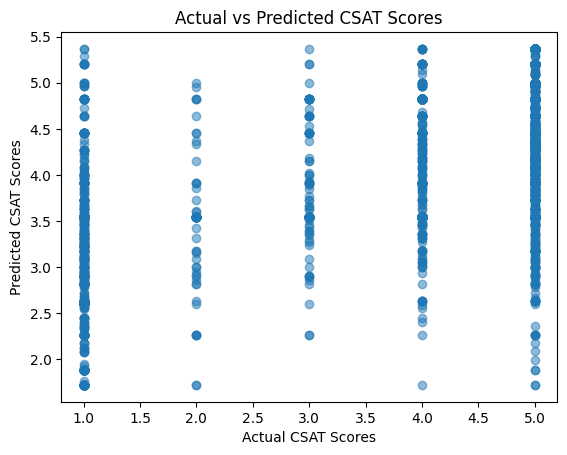

   Actual_CSAT_Score  Predicted_CSAT_Score
0                  5              4.820131
1                  2              5.002546
2                  1              3.543225
3                  4              3.543225
4                  5              3.923256
5                  5              3.543225
6                  5              5.367376
7                  5              3.908055
8                  5              4.820131
9                  1              3.543225


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
# Assuming your DataFrame is named 'cleaned_df' and you've already added 'sentiment_polarity' to it
# and your sentiment scores are properly scaled/encoded

# First, check the correlation
correlation = cleaned_df[['sentiment_score', 'CSAT_Score']].corr()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cleaned_df[['sentiment_score']], 
                                                    cleaned_df['CSAT_Score'], 
                                                    test_size=0.2, 
                                                    random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict CSAT scores on the testing set
predicted = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

# Printing the results
print("Correlation Matrix:\n", correlation)
print("\nMean Squared Error:", mse)
print("R-squared:", r2)
# Scatter plot for actual vs predicted CSAT scores
plt.scatter(y_test, predicted, alpha=0.5)
plt.xlabel('Actual CSAT Scores')
plt.ylabel('Predicted CSAT Scores')
plt.title('Actual vs Predicted CSAT Scores')
plt.show()

# Create a DataFrame with actual and predicted CSAT scores
comparison_df = pd.DataFrame({'Actual_CSAT_Score': y_test, 'Predicted_CSAT_Score': predicted})

# Reset index to get a neat DataFrame without the old index
# If you wish to keep the old index, just remove '.reset_index(drop=True)'
comparison_df = comparison_df.reset_index(drop=True)

# Display the DataFrame
print(comparison_df.head(10))  # Display the first 10 rows

In [12]:
%pip install -U pip setuptools wheel  # Update packaging tools
%pip install -U transformers          # Update the transformers library



Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'


In [13]:
from transformers import pipeline

# Load a pre-trained, fine-tuned BERT model for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis")

# Define a function to calculate sentiment using BERT
def calculate_bert_sentiment(text):
    if pd.isna(text):
        return 0  # or you might choose to return None or any neutral value
    result = sentiment_pipeline(text)
    # The result is a list of dictionaries, each containing a label and a score
    # For a simple sentiment score, we can take the score from the positive label
    return result[0]['score'] if result[0]['label'] == 'POSITIVE' else -result[0]['score']

# Apply the function to the Customer_Remarks column
cleaned_df['bert_sentiment'] = cleaned_df['Customer_Remarks'].apply(calculate_bert_sentiment)

# Show the first few entries of the new sentiment scores
print(cleaned_df[['Customer_Remarks', 'bert_sentiment']].head())


ModuleNotFoundError: No module named 'transformers.utils'